In [1]:
import fastai
from fastai import *
from fastai.vision import *

In [2]:
fastai.__version__

'1.0.39'

In [3]:
path = Path("/kaggle/input/train/train/")
sub = pd.read_csv("/kaggle/input/sample-submission.csv")

In [4]:
data = ImageDataBunch.from_folder(path=path, train=".", valid_pct=0.3, ds_tfms=get_transforms(), size=140, bs=16, test="/kaggle/input/test/test/")

In [5]:
data.classes

['0', '1', '2', '3']

In [6]:
print(f"Lenght Of Train Dataset : {len(data.train_ds)}")
print(f"Lenght Of Valid Dataset : {len(data.valid_ds)}")
print(f"Lenght Of Test Dataset : {len(data.test_ds)}")
print(f"Number of Classes : {data.c}")

Lenght Of Train Dataset : 2520
Lenght Of Valid Dataset : 1080
Lenght Of Test Dataset : 800
Number of Classes : 4


In [7]:
print(f"Label 0 is : Accident")
print(f"Label 1 is : Dense Traffic")
print(f"Label 2 is : Vehicle On Fire")
print(f"Label 3 is : Sparse Traffic")

Label 0 is : Accident
Label 1 is : Dense Traffic
Label 2 is : Vehicle On Fire
Label 3 is : Sparse Traffic


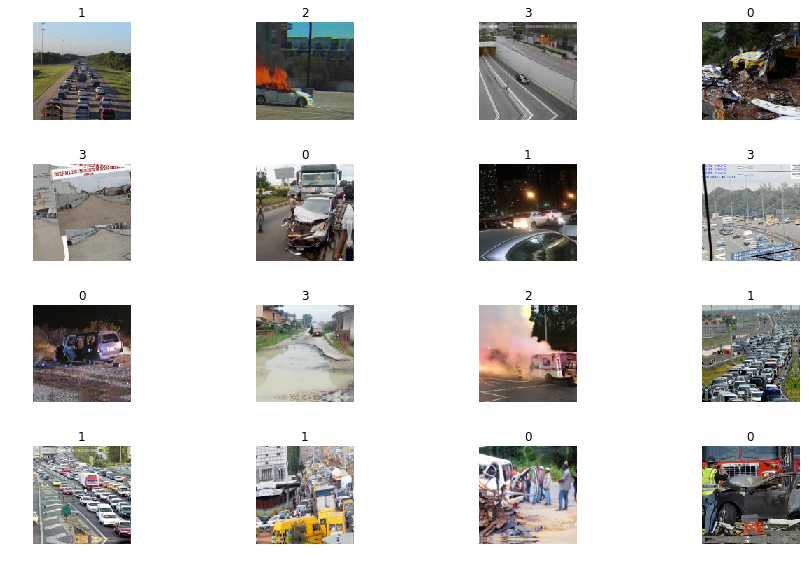

In [8]:
data.show_batch(4,figsize=(13,8))

**Train Model**

In [9]:
model = create_cnn(data, models.resnet152, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 81549445.20it/s]


In [10]:
model.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy
1,0.638168,0.348174,0.875926
2,0.431212,0.290828,0.908333
3,0.325003,0.264033,0.906482


In [11]:
classif = ClassificationInterpretation.from_learner(model)

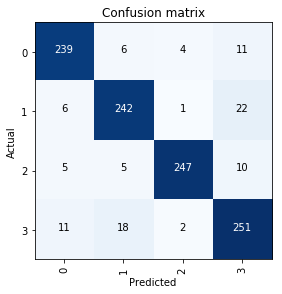

In [12]:
classif.plot_confusion_matrix()

In [13]:
losses,idxs = classif.top_losses()

In [14]:
top_loss = data.valid_ds.x[idxs]

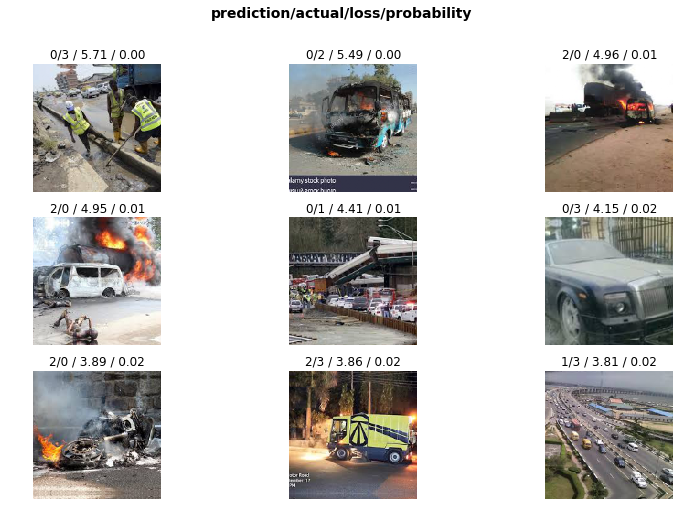

In [15]:
classif.plot_top_losses(9, figsize=(13,8))

** Let's Train Some more**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


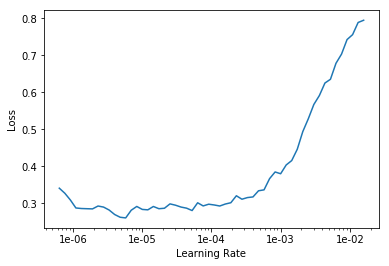

In [16]:
model.unfreeze()
model.lr_find()
model.recorder.plot()

In [17]:
model.fit_one_cycle(8, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.292465,0.241417,0.914815
2,0.269753,0.225861,0.925000
3,0.232430,0.214224,0.932407
4,0.215619,0.214401,0.929630
5,0.194497,0.210168,0.926852
6,0.203087,0.205514,0.928704
7,0.177458,0.201409,0.927778
8,0.149314,0.203842,0.931481


**Submission**

In [18]:
#Prediction of the Test Set
preds_test, y_test=model.get_preds(ds_type=DatasetType.Test)

In [19]:
predz = np.argmax(preds_test, axis=1)

In [20]:
sub = pd.read_csv("/kaggle/input/sample-submission.csv").set_index('ImageID')
sub.head()

,Category
ImageID,
00525fa2-c886-4f4d-8bf7-fbb72c6185f5.jpg,9
00683a08-bafe-4569-9e60-138b1c33e377.jpg,9
007eef35-f0c8-406e-ab13-a53ff5f7135d.jpg,9
00b62a38-8eac-4a5f-92b4-cbe22bd86235.jpg,9
010aca1b-e14a-4ff8-9263-5a2a84e8ef7a.jpg,4


In [21]:
names=np.vectorize(lambda img_name: str(img_name).split('/')[-1]) 
file_names= names(data.test_ds.items).astype(str)
file_names[0]

'56e9e934-f9c0-47bd-89cf-de588a805893.jpg'

In [22]:
sub.loc[file_names,'Category']=predz.numpy()

In [23]:
sub.reset_index(inplace=True)
sub.head()

,ImageID,Category
0,00525fa2-c886-4f4d-8bf7-fbb72c6185f5.jpg,1
1,00683a08-bafe-4569-9e60-138b1c33e377.jpg,2
2,007eef35-f0c8-406e-ab13-a53ff5f7135d.jpg,1
3,00b62a38-8eac-4a5f-92b4-cbe22bd86235.jpg,0
4,010aca1b-e14a-4ff8-9263-5a2a84e8ef7a.jpg,1


> **The code below was from Rachel Tatman's Kaggle kernel Downloading a .csv file from Kernel and tweaked to what i need**
*  **Link:** *https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel*

In [24]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data2.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(sub, filename="hackexposub.csv")